# Approximation

<div class="alert alert-block alert-info">
    <img style="float: right;" src="https://raw.githubusercontent.com/OpenSourceEconomics/ose-corporate-design/master/logos/OSE_logo_RGB.svg" width="150">
    <u><h1>Setup</h1></u>
</div>

In many computational economics applications, we need to replace an analytically intractable function $f : R^n \rightarrow R$ with a numerically tractable approximation $\hat{f}$. In some applications, f can be evaluated at any point of its domain, but with difficulty, and we wish to replace it with an approximation $\hat{f}$ that is easier to work with.

We study interpolation, a general strategy for forming a tractable approximation to a function that can be evaluated at any point of its domain. Consider a real-valued function $f$ defined on an interval of the real line that can be evaluated at any point of its domain.

Generally, we will approximate $f$ using a function $\hat{f}$ that is a finite linear combination of n known basis functions $\phi_1, \phi_2, ..., \phi_n$ of our choosing:

\begin{align*}
f(x) \approx \hat{f}(x) \equiv \sum_{j=1}^n c_j \phi_j(x).
\end{align*}

We will fix the n basis coefficients $c_1 , c_2 , ... , c_n$ by requiring $\hat{f}$ to interpolate, that is, agree with $f$ , at $n$ interpolation nodes $x_1 , x_2 , ... , x_n$ of our choosing. 

The most readily recognizable basis is the monomial basis:

\begin{align*}
\phi_0(x) &= 1 \\
\phi_1(x) &= x \\
\phi_2(x) &= x^2 \\
. \\
\phi_n(x)& x^n
\end{align*}

This can be used to construct the polynomial approximations:

\begin{align*}
f(x) \approx \hat{f}(x) \equiv c_0 + c_1 x +  c_2 x^2 +  ... c_n x^n
\end{align*}

There are other basis functions with more desirable properties and there are many different ways to choose the interpolation nodes.

Regardless of how the $n$ basis functions and nodes are chosen, computing the basis coefficients reduces to solving a linear equation.

\begin{align*}
\sum_{j=1}^n = c_j \phi_j(x) = f(x), \qquad i = 1, ..., n
\end{align*}

Interpolation schemes differ only in how the basis functions $\phi_j$ and interpolation nodes $x_j$ are chosen.




In [3]:
from functools import partial
import warnings

import matplotlib.pyplot as plt
import numpy as np

from approximation_algorithms import get_interpolator_flexible_basis_flexible_nodes
from approximation_algorithms import get_interpolator_monomial_flexible_nodes
from approximation_algorithms import get_interpolator_monomial_uniform
from approximation_algorithms import get_interpolator_runge_baseline

from approximation_auxiliary import compute_interpolation_error
from approximation_auxiliary import get_chebyshev_nodes
from approximation_auxiliary import get_uniform_nodes

from approximation_plots import plot_reciprocal_exponential
from approximation_plots import plot_runge_different_nodes
from approximation_plots import plot_approximation_nodes
from approximation_plots import plot_basis_functions
from approximation_plots import plot_runge_multiple
from approximation_plots import plot_problem_runge


from approximation_problems import problem_reciprocal_exponential
from approximation_problems import problem_runge

<div class="alert alert-block alert-info">
    <u><h2>Polynomial interpolation</h2></u>
</div>

A polynomial is an expression consisting of variables and coefficients, that involves only the operations of addition, subtraction, multiplication, and non-negative integer exponentiation of variables. 

The Weierstrass Theorem asserts that any continuous real-valued function can be approximated to an arbitrary degree of accuracy over a bounded interval by a polynomial.

Specifically, if $f$ is continuous on $[a, b]$ and $\epsilon > 0$, then there exists a polynomial $p$ such that 

\begin{align*}
\max_{x\in[a, b]} |f(x) - p(x)| < \epsilon
\end{align*}

* How to find a polynomial that provides a desired degree of accuracy?

* What degree of the polynomial is required?


###  Naive polynomial interpolation

Let's start with a basic setup, where we use a uniform grid and monomial basis functions.

\begin{align*}
\hat{f}(x) \equiv \sum_{j=0}^n c_j x^j
\end{align*}

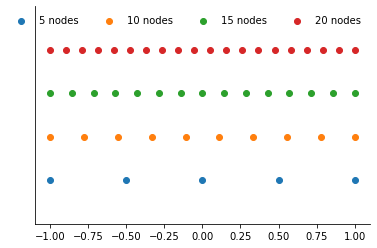

In [4]:
plot_approximation_nodes([5, 10, 15, 20], strategy="uniform")

Now we can get a look at the interpolation nodes.

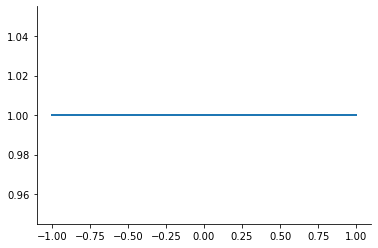

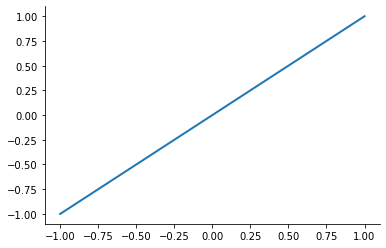

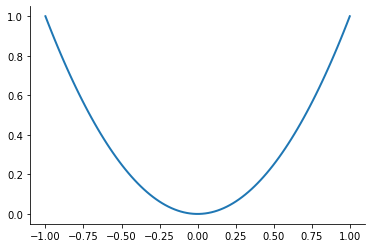

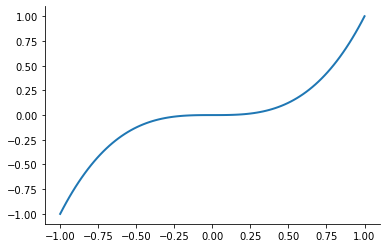

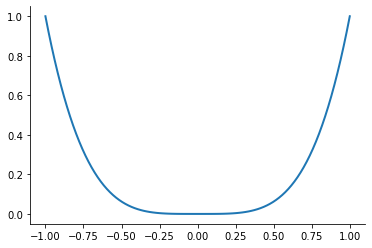

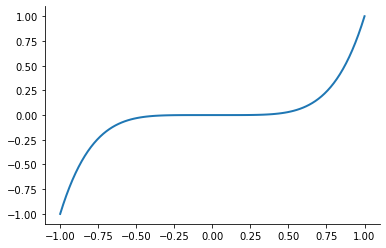

In [5]:
plot_basis_functions("monomial")

In [6]:
??get_uniform_nodes

Signature: get_uniform_nodes(n, a=-1, b=1)
Docstring: <no docstring>
Source:   
def get_uniform_nodes(n, a=-1, b=1):

    nodes = np.tile(np.nan, n)

    for i in range(1, n + 1):
        nodes[i - 1] = a + (i - 1) / (n - 1) * (b - a)

    return nodes
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/approximation/approximation_auxiliary.py
Type:      function


Let's look at the performance of this approach for the Runge function for $x\in[0, 1]$.

\begin{align*}
f(x) = \frac{1}{(1 + 25 x^2)}
\end{align*}

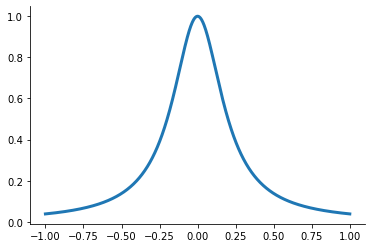

In [7]:
plot_problem_runge()

Due to its frequent use, `numpy` does offer a convenience class to work with polynomials. See [here](https://numpy.org/devdocs/reference/routines.polynomials.html) for its documentation.

In [8]:
from numpy.polynomial import Polynomial as P
from numpy.polynomial import Chebyshev as C

We will use the attached methods to develop a flexible interpolation set in an iterative fashion.'

In [9]:
??get_interpolator_runge_baseline

Signature: get_interpolator_runge_baseline(func)
Docstring: <no docstring>
Source:   
def get_interpolator_runge_baseline(func):
    xnodes = np.linspace(-1, 1, 5)
    poly = P.fit(xnodes, func(xnodes), 5)
    return poly
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/approximation/approximation_algorithms.py
Type:      function


In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    interpolant = get_interpolator_runge_baseline(problem_runge)
    xvalues = np.linspace(-1, 1, 10000)
    yfit = interpolant(xvalues)

<div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li>Why the warnings?</li>
    </ul> 
</div>

In [11]:
warnings.simplefilter("ignore")

Now we are read to plot it against the true function.

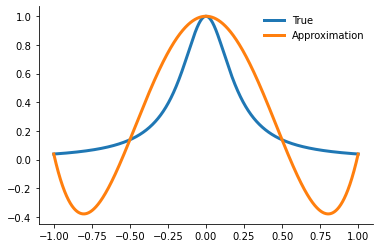

In [12]:
fig, ax = plt.subplots()
ax.plot(xvalues, problem_runge(xvalues), label="True")
ax.plot(xvalues, yfit, label="Approximation")
ax.legend()

We evaluate the error in our approximation by the  the following statistic.

In [13]:
??compute_interpolation_error

Signature: compute_interpolation_error(error)
Docstring: <no docstring>
Source:   
def compute_interpolation_error(error):
    return np.log10(np.linalg.norm(error, np.inf))
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/approximation/approximation_auxiliary.py
Type:      function


In [14]:
compute_interpolation_error(yfit - problem_runge(xvalues))

-0.3581719202049975

<div class="alert alert-warning">
    <h3>Exercises</h3>  
     <ul>
      <li> Generalize the function to allow to approximate the function with a polynomial of generic degree.</li>
      <li> How does the quality of the approximation change as we increase the number of interpolation points.</li>         
    </ul> 
</div>

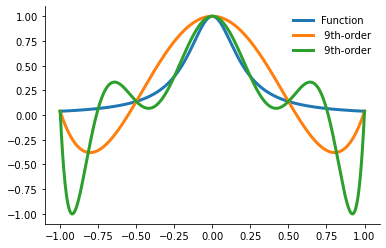

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_runge_multiple()

What can be done? First we explore a different way to choose the the nodes.

Theory asserts that the best way to approximate a continuous function with a polynomial over a bounded interval $[a, b]$ is to interpolate it at so called Chebychev nodes:

\begin{align*}
x_i = \frac{a + b}{2} + \frac{b - a}{2}\cos\left(\frac{n - i + 0.5}{n}\pi\right)
\end{align*}



In [13]:
??get_chebyshev_nodes

Signature: get_chebyshev_nodes(n, a=-1, b=1)
Docstring: <no docstring>
Source:   
def get_chebyshev_nodes(n, a=-1, b=1):

    nodes = np.tile(np.nan, n)

    for i in range(1, n + 1):
        nodes[i - 1] = (a + b) / 2 + ((b - a) / 2) * np.cos(((n - i + 0.5) / n) * np.pi)

    return nodes
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/approximation/approximation_auxiliary.py
Type:      function


Let's look at a visual representation.

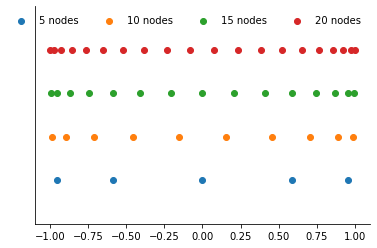

In [14]:
plot_approximation_nodes([5, 10, 15, 20], strategy="chebychev")

The Chebychev nodes are not evenly spaced and do not include the endpoints of the approximation interval. They are more closely spaced near the endpoints of the approximation interval and less so near the center.


If $f$ is continuous ...

* Rivlin’s Theorem asserts that Chebychev-node polynomial interpolation is nearly optimal, that is, it affords an approximation error that is very close to the lowest error attainable with another polynomial of the same degree.

* Jackson’s Theorem asserts that Chebychev-node polynomial interpolation is consistent, that is, the approximation error vanishes as the degree of the polynomial increases.

In [15]:
??get_interpolator_monomial_flexible_nodes

Signature:
get_interpolator_monomial_flexible_nodes(
    func,
    degree,
    nodes='uniform',
    a=-1,
    b=1,
)
Docstring: <no docstring>
Source:   
def get_interpolator_monomial_flexible_nodes(
    func, degree, nodes="uniform", a=-1, b=1
):

    if nodes == "uniform":
        get_nodes = get_uniform_nodes
    elif nodes == "chebychev":
        get_nodes = get_chebyshev_nodes

    xnodes = get_nodes(degree, a, b)
    poly = P.fit(xnodes, func(xnodes), degree)

    return poly
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/approximation/approximation_algorithms.py
Type:      function


In [16]:
intertp = get_interpolator_monomial_flexible_nodes(problem_runge, 11, nodes="chebychev")
intertp(np.linspace(-1, 1, 10))

array([-0.0053,  0.0418,  0.1289,  0.2083,  0.8551,  0.8551,  0.2083,
        0.1289,  0.0418, -0.0053])

Let's compare the performance of the two approaches.

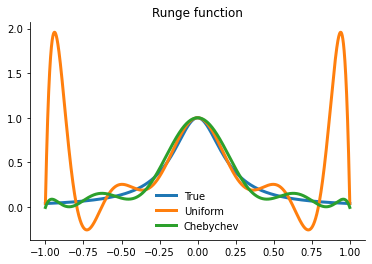

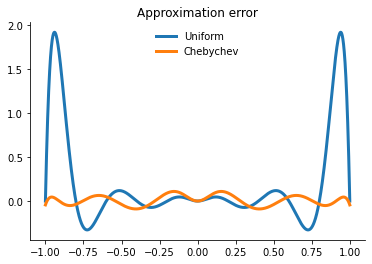

In [17]:
plot_runge_different_nodes()

However, merely interpolating at the Chebychev nodes does not eliminate ill-conditioning. Ill-conditioning stems from the choice of basis functions,
not the choice of interpolation nodes. Fortunately, there is alternative to the monomial basis that is ideal for expressing Chebychev-node polynomial interpolants. The optimal basis for expressing Chebychev-node
polynomial interpolants is called the Chebychev polynomial basis.

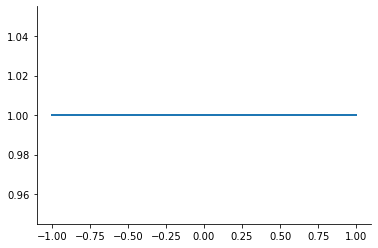

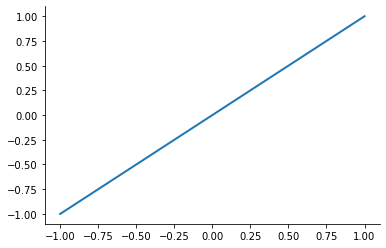

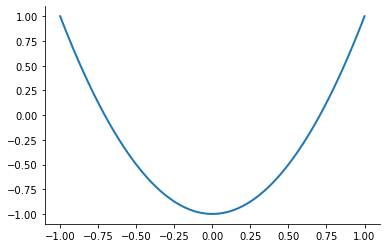

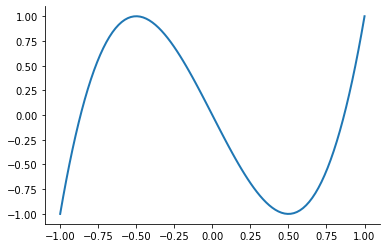

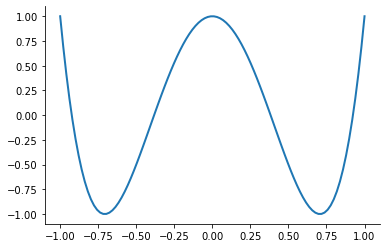

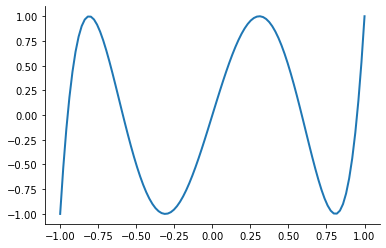

In [18]:
plot_basis_functions("chebychev")

Combining the Chebychev basis polynomials and Chebychev interpolation nodes yields an extremely well-conditioned interpolation equation and allows to approximate any continuous function to high precision. Let's put it all together now.

In [19]:
??get_interpolator_flexible_basis_flexible_nodes

Signature:
get_interpolator_flexible_basis_flexible_nodes(
    func,
    degree,
    basis='monomial',
    nodes='uniform',
    a=-1,
    b=1,
)
Docstring: <no docstring>
Source:   
def get_interpolator_flexible_basis_flexible_nodes(
    func, degree, basis="monomial", nodes="uniform", a=-1, b=1
):

    if nodes == "uniform":
        get_nodes = get_uniform_nodes
    elif nodes == "chebychev":
        get_nodes = get_chebyshev_nodes

    if basis == "monomial":
        fit = P.fit
    elif basis == "chebychev":
        fit = C.fit

    xnodes = get_nodes(degree, a, b)
    poly = fit(xnodes, func(xnodes), degree)

    return poly
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/approximation/approximation_algorithms.py
Type:      function


How well can we actually do now?

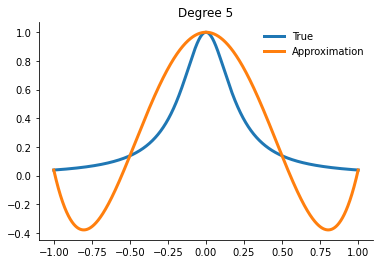

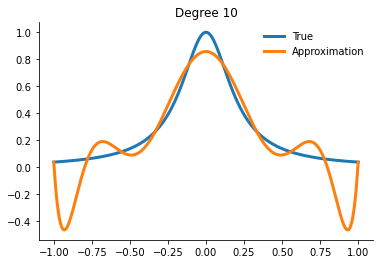

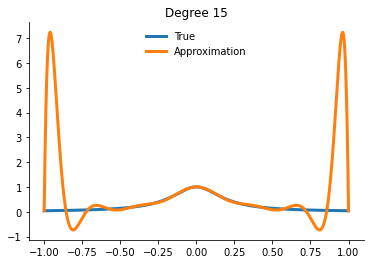

In [20]:
for degree in [5, 10, 15]:
    interp = get_interpolator_flexible_basis_flexible_nodes(
        problem_runge, degree, nodes="uniform", basis="monomial"
    )
    xvalues = np.linspace(-1, 1, 10000)
    yfit = interp(xvalues)

    fig, ax = plt.subplots()
    ax.plot(xvalues, problem_runge(xvalues), label="True")
    ax.plot(xvalues, yfit, label="Approximation")
    ax.legend()
    ax.set_title(f"Degree {degree}")

### Research

*

### Resources

* https://relate.cs.illinois.edu/course/cs450-f18/file-version/a7a1965adf0479d36f1a34889afe55e2ec61a532/demos/upload/07-interpolation/Chebyshev%20interpolation.html

* https://www.unioviedo.es/compnum/labs/PYTHON/Interpolation.html

* https://www.johndcook.com/blog/2017/11/06/chebyshev-interpolation/

* https://numpy.org/devdocs/reference/routines.polynomials.html

### References

* 